<a href="https://colab.research.google.com/github/RLandryD/DataSCience/blob/main/Custom_Object_Detection_YOLOv5_LOPCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

SEED = 42
np.random.seed(SEED)

In [2]:
!ls

sample_data


In [3]:
TRAIN = True
# Number of epochs to train for
EPOCHS = 25

In [9]:
if not os.path.exists('train'):
  !curl -L "https://public.roboflow.com/ds/xKLV14HbTF?key=aJzo7msVta" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  dirs = ['train', 'valid', 'test']

  for i, dir_name in enumerate(dirs):
    all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
    for j, image_name in enumerate(all_image_names):
      if (j % 2) == 0:
        file_name = image_name.split('.jpg')[0]
        os.remove(f"{dir_name}/images/{image_name}")
        os.remove(f"{dir_name}/labels/{file_name}.txt")

In [12]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [13]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
  xmin, ymin = bboxes[0] - bboxes[2]/2, bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0] + bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return xmin, ymin, xmax, ymax

In [25]:
def plot_box(image, bboxes, labels):
             # Need the image height and width to denormalize
             # The bounding box coordinates
             h, w, _ = image.shape
             for box_num, box in enumerate(bboxes):
               x1, y1, x2, y2 = yolo2bbox(box)
               # denormalize the coordinates
               xmin = int(x1*w)
               ymin = int(y1*h)
               xmax = int(x2*w)
               ymax = int(y2*h)

               class_name = class_names[int(labels[box_num])]

               cv2.rectangle(
                   image,
                   (xmin, ymin), (xmax, ymax),
                   color=colors[class_names.index(class_name)],
                   thickness=2,
               )
               
               font_scale = min(1,max(3,int(w/500)))
               font_thickness = min(2, max(10,int(w/50)))
               cv2.putText(
                   image,
                   class_name,
                   (xmin+1, ymin-10),
                   cv2.FONT_HERSHEY_SIMPLEX,
                   font_scale,
                   (255, 255, 255),
                   font_thickness
               )
               return image

In [28]:
# Function to plot images with the bounding boxes
def plot(image_paths, label_paths, num_samples):
  all_training_images = glob.glob(image_paths)
  all_training_labels = glob.glob(label_paths)
  all_training_images.sort()
  all_training_labels.sort()

  num_images = len(all_training_images)
  plt.figure(figsize=(15,12))
  for i in range(num_samples):
    j = random.randint(0,num_images-1)
    image = cv2.imread(all_training_images[j])
    with open(all_training_labels[j], 'r') as f:
      bboxes = []
      labels = []
      label_lines = f.readlines()
      for label_line in label_lines:
        label = label_line[0]
        bbox_string = label_line[2:]
        x_c, y_c, w, h = bbox_string.split(' ')
        x_c = float(x_c)
        y_c = float(y_c)
        w = float(w)
        h = float(h)
        bboxes.append([x_c, y_c, w, h])
        labels.append(label)
      result_image = plot_box(image, bboxes,  labels)
      plt.subplot(2, 2, i+1)
      plt.imshow(result_image[:, :, ::-1])
      plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

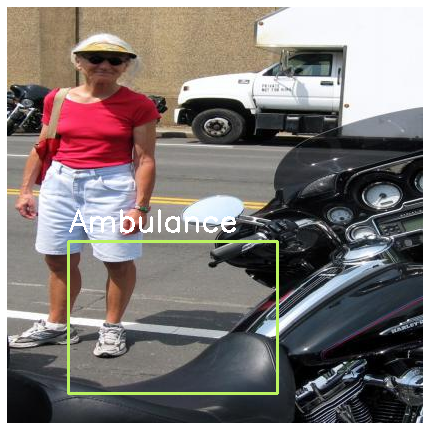

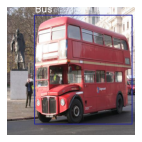

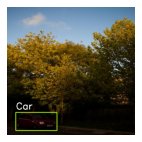

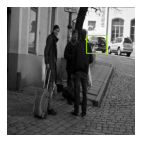

In [31]:
# Visualize a few training images.
plot(
    image_paths='train/images/*',
     label_paths='train/labels/*',
     num_samples=4,
)